In [1]:
import warnings
warnings.filterwarnings(action='ignore')
%config Completer.use_jedi = False
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'NanumGothicCoding'
plt.rcParams['font.size'] = 10
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import datasets 
from tensorflow.keras.models import  Sequential 
from tensorflow.keras.layers import Dense 

# tensorflow에서 순환 신경망(Recurrent Neural Network, RNN)을 사용하기 위해 추가
from tensorflow.keras.layers import Conv1D # 신경망에 추가할 합성곱 레이어를 생성하기 위해 import
from tensorflow.keras.layers import MaxPool1D # 신경망에 추가할 맥스 풀링 레이어를 생성하기 위해 import
from tensorflow.keras.layers import Dropout # 신경망에 추가할 드랍 다운 레이어를 생성하기 위해 import
# 임베딩이란 사람이 쓰는 자연어를 기계가 이해할 수 있는 숫자의 나열인 벡터로 바꾼 결과 혹은 과정을 의미한다.
# 임베딩의 가장 간단한 형태는 단어의 빈도를 그대로 벡터로 사용하는 방법이다.
from tensorflow.keras.layers import Embedding # 신경망에 추가할 임베딩 레이어를 생성하기 위해 import
from tensorflow.keras.layers import LSTM #신경망에 추가할 LSTM 레이어를 생성하기 위해 import
# RNN은 항상 같은 길이의 시퀀스를 받아야 하기때문에 제각기 다른 피쳐 데이터의 길이를 일치시켜야한다.
from tensorflow.keras.preprocessing import sequence  # 피쳐 데이터 값의 길이를 일치시키기 위해 import

***
순환 신경망(RNN)
***
순환 신경망은 시퀀스(sequence) 데이터를 사용한다.  
시퀀스 데이터는 다른 말로 하면 시계열(time series) 데이터라고도 말하며, 시점에 따라서 데이터가 달라지는 것을 의미한다.  
즉, 특정 시점에서 데이터를 한번에 수집하는 것이 아니라 시간의 흐름에 따라서 데이터를 점차 수집하는 것을 의미한다.  
전체 데이터셋을 구성하는 각 데이터 포인트의 수집 시점이 다르다.  

지금까지 다른 신경망은 입력 데이터를 사용한 후 그 결과가 다시 입력층으로 돌아가지 않았다.  
즉, 한번 출력된 결과를 다시 사용하지 않았다.  이를 피드 포워드(Feed Forward) 신경망이라 한다.  
반면, 순환 신경망은 출력된 결과가 다음 시점에서 사용된다.  
즉, 출력 결과를 다음 시점까지 기억했다가 사용하는 방식이다.  

<img src="./RNN (1).png">

***
LSTM(Long Short Term Memory)
***

순환 신경망은 은닉층을 거친 결과값을 재사용하는 특징이 있다. 그러나 그로인해 기울기 소멸 문제(Vanishing Gradient Problem)나 기울기 폭주 문제(Exploding Gradient Problem)가 발생할 수 있다.  
기울기 소멸 문제는 학습이 진행되는 과정에서 기울기가 점점 줄어들어 사라지는 현상을 의미하고,  
기울기 폭주는 학습 과정에서 기울기가 점점 커져 폭주하는 현상을 말한다.  

LSTM은 기울기 소멸이나 폭주문제를 해결하기 위해 만든 방법이다. LSTM에서는 결과값이 다음 시점으로 넘어갈 때 결과값을 넘길지 말지 결정하는 단계가 추가된다.

<img src="RNN (2).png">

***
순환 신경망을 이용해 영화 리뷰 감성 분석 모델을 생성해본다. 
***

In [2]:
# 일관된 결과값이 나오도록 numpy와 tensorflow의 seed를 설정한다. 
np.random.seed(0)
tf.random.set_seed(0)

***
순환 신경망에 사용할 데이터 준비
***
IMDB Movie Review Sentimental Analysis  
감성 분류를 연습하기 위해 자주 사용하는 영어 데이터로 영화 사이트 IMDB 리뷰 데이터가 있다.   
이 데이터는 리뷰에 대한 텍스트와 리뷰가 긍정적인 경우 1을 부정적인 경우 0으로 표시한 레이블 데이터로 스탠포드 대학교에서 2011년 낸 논문에서 이 데이터를 소개하였으며,  
당시 논문에서 데이터를 훈련 데이터와 테스트 데이터를 5:5 비율로 분할하여 88.89%의 정확도를 얻었다고 소개하고 있다.  

In [3]:
# IMDB 영화 리뷰 데이터는 학습 데이터와 테스트 데이터가 튜플로 구분돼 저장되어 있다.
# load_data() 메소드는 (학습 피쳐 데이터, 학습 레이블 데이터)와 (테스트 피쳐 데이터, 테스트 레이블 데이터)를 튜플 형태로 묶어서 리턴한다. 
# IMDB 영화 리뷰 데이터셋을 학습 데이터와 테스트 데이터로 저장한다.
# num_words 속성을 사용해서 데이터에서 등장 빈도 순위로 몇 등까지의 단어를 사용할 것인지 지정할 수 있다.
# 예를 들어 10000을 넣으면 등장 빈도 순위가 1위에서 10000위에 해당되는 단어만 사용하게 된다.
(x_train, y_train), (x_test, y_test) = datasets.imdb.load_data(num_words=2000)

#오리지널 데이터 확인
# 학습 데이터, 레이블, 테스트 데이터, 레이블 모두 25000개의 벡터 데이터로 이루어져있다.
print(type(x_train), x_train.shape) 
print(type(x_test), x_test.shape) 
print(type(y_train), y_train.shape) 
print(type(y_test),y_test.shape)

<class 'numpy.ndarray'> (25000,)
<class 'numpy.ndarray'> (25000,)
<class 'numpy.ndarray'> (25000,)
<class 'numpy.ndarray'> (25000,)


In [4]:
# 학습 데이터를 학습 데이터셋과 검증 데이터셋으로 분리
# 25000개의 학습 데이터 중에서 데이터 뒷쪽 5000개의 데이터를 검증 데이터로 따로 저장한다.
x_valid = x_train[20000:] # 학습 피쳐 데이터 25000개 중에 검증에 사용할 데이터 5000개
x_train = x_train[:20000] # 학습 피쳐 데이터 25000개 중에 학습에 사용할 데이터 20000개
y_valid = y_train[20000:] # 학습 레이블 데이터 25000개 중에 검증에 사용할 데이터 5000개
y_train = y_train[:20000] # 학습 레이블 데이터 25000개 중에 학습에 사용할 데이터 20000개
print(x_train.shape, y_train.shape, x_valid.shape, y_valid.shape)

(20000,) (20000,) (5000,) (5000,)


In [5]:
# 데이터 형태 확인
# 학습 피쳐 데이터 값을 확인해보면 숫자로 이루어진 리스트라는 것을 알 수 있다. 
# 이는 오리지널 데이터에 이미 단어를 숫자 매핑을 해놓아 영어 단어가 해당되는 숫자로 변환된 것임을 알수 있다.
print(x_train[0])
print("="* 50)
print( y_train[0])
print( y_train[1])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 2, 66, 2, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 2, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 1920, 2, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2, 2, 16, 480, 66, 2, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 2, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]
1
0


In [6]:
# 개별 피쳐 데이터 크기 확인
# 학습 피쳐 데이터의 가장 처음에 나오는 두 개의 값을 확인해 본 결과 문장의 길이가 다르다는 것을 알수 있다.
print(len(x_train[0]))
print(len(x_train[1]))
total = 0
for i in range(len(x_train)):
     total += len(x_train[i])
print(total // len(x_train))

218
189
238


In [7]:
# 피쳐 데이터를 변형
# RNN은 항상 같은 길이의 시퀀스를 받아야하므로 문장을 구성하는 단어의 갯수를 같은 크기로 조절해줘야한다.  
# pad_sequences() 메소드로 피쳐 데이터를 넘기고, maxlen 속성으로 단어의 갯수를 넘겨 같은 크기로 맞춘다.
# maxlen 속성을 생략하면 가장 긴 길이가 기본값으로 사용되고, maxlen 속성을 지정하면 모자라는 부분은 0으로 채우고,
# 넘치는 데이터는 삭제된다.
x_train = sequence.pad_sequences(x_train, maxlen=200)
x_valid = sequence.pad_sequences(x_valid, maxlen=200)
x_test = sequence.pad_sequences(x_test, maxlen=200)

In [8]:
# 클래스(레이블)의 종류 확인
# 클래스의 종류를 확인함으로써 분류 문제인지 회귀 문제인지 파악할 수 있고, 
# 분류 문제라면 몇가지 클래스로 구분되는지 알 수 있다. 
print(set(y_train), set(y_test))

{0, 1} {0, 1}


***
순환 신경망 모델을 만든다.
***

In [9]:
# Sequential() 객체 선언 후 Sequential 모델에 add() 메소드로 레이어를 추가해 신경망을 만든다.
model = Sequential() # 시퀀스를 사용하는 신경망 모델을 만든다.

#-------------  임베딩 레이어 추가-------------------
# 신경망 모델에 임베딩 레이어를 추가한다.
# 리뷰 1건당 총 2000개의 단어를 사용함으로 입력되는 피쳐 갯수는 2000개이므로
# input_dim 속성에 2000을 지정한다.
# 리뷰 1건당 단어 갯수(maxlen)는 200개로 맞췄으므로 output_dim 속성에 200을 지정한다.
# 임베딩 레이어의 Output Shape은 output_dim 속성값으로 결정된다. (None, None, 200)
# 임베딩 레이어의 Param은 [input_dim 속성값 * output_dim 속성값]으로 결정된다.
model.add(Embedding(input_dim=2000 , output_dim=200))

# --------------- Conv1D 레이어 추가 -----------------
# 합성곱 신경망은 2차원 데이터를 사용해서 Conv2D 레이어를 사용하지만,
# LSTM은 1차원 데이터를 사용해서 Conv1D 레이어를 사용한다. 
# 신경망 모델의 Conv1D 레이어를 추가한다.

# filters 속성으로 출력되는 데이터의 출력 차원을 지정한다. ;  레이어를 구성하는 노드의 갯수를 지정한다.
# kernel_size 속성으로 커널의 크기를 지정한다.
# 커널 크기는 Conv2D는 2차원 데이터를 사용하므로 커널 크기도 (행, 열)과 같은 2차원으로 지정했지만,
# Conv1D는 1차원 데이터를 사용하므로 커널 크기도 1차원으로 지정해야한다.
# padding 속성으로 패딩 여부를 지정한다. 기본값은 "valid"로 패딩을 적용하지 않고, "same"은 패딩을 적용한다.
# activation 속성으로 활성화 함수를 지정한다.
# Conv1D 레이어의 Output Shape은 filters 속성값의 크기로 결정된다. (None, None, 50)
# Conv1D 레이어의 Param은 [커널의 크기 * 입력 채널 크기 *  필터 크기 + 필터마다 1개의 바이어스]로 결정된다.
# 커널의 크기(3) * 입력 채널의 크기(200) * 필터 크기(50) + 필터마다 1개의 바이어스 (50) = 30050
model.add( Conv1D(filters = 50 , kernel_size = (3), padding="valid", activation = "relu" ))

#---------------- 맥스 풀링 레이어 -----------------------
#신경망 모델에 맥스 풀링 레이어를 추가한다.
#pool_size 속성으로 맥스 풀링을 실행할 픽셀 크기를 지정한다. 기본값 (2, 2) 이다.
# MaxPoolD 레이어의 output shape은 맥스 풀링 레이어에 입력되는 크기로 결정된다. (None, None, 50)
# MaxPool1D 레이어의 Param은 없으므로 0이다.
model.add(MaxPool1D(pool_size = 3))

#---------------- LSTM 레이어 --------------------------
# 신경망 모델에 LSTM 레이어를 추가한다. LSTM 레이어는 4개의 층으로 구성되어 있다. 
# LSTM 레이어는 units 속성으로 레이어의 출력 차원, activation 속성으로 tanh 활성화 함수를 지정한다.
# LSTM 레이어의 output shape은 units 속성에 입력하는 크기로 결정된다. (None, 100)
# LSTM 레이어의 Param은 [(입력 채널 크기 + units 속성값 + 바이어스(1)) * units 속성값 * LSTM 레이어의 층의 갯수]로 결정된다.
# [(입력 채널 크기(50) + units 속성값(100) + 바이어스(1)) * units 속성값(100) * LSTM 레이어의 층의 갯수(4)] = 60400

model.add(LSTM(units = 100, activation="tanh"))

#----------------- 드롭아웃 레이어 -----------------------
# 신경망 모델에 드롭아웃 레이어를 추가한다.
# rate 속성으로 드롭아웃(사용하지 않을)할 노드이 비율을 지정한다.
# Dropout 레이어의 Output Shape 입력 shape와 같다. (None , 100)
# Droptout 레이어의  Param은 없으므로 0이다.

model.add(Dropout(rate = 0.25))

# ------------------ 최종 출력 레이어 -------------------------------
# 신경망 모델에 최종 출력 레이어를 추가한다. 최종 출력 레이어는 Dense 레이어로 구성한다.
# 이진 분류( 0 또는 1) 모델이므로 units 속성값은 1로 지정한다. 
# 다중 분류의 경우 레이블 데이터를 원-핫 인코딩으로 변환해서 신경망에 입력해야하고 units 속성값은 분류할 클래스의 갯수로 지정하면 된다.
# activation 속성으로 이진 분류이므로 sigmoid를 지정한다.
# Dense 레이어의 Output Shape은 units 속성의 크기로 결정된다. (None, 1)
# Dense 레이어의 Param은 [(입력 채널 크기(100) + 바이어스(1) ) * 출력 차원 크기(1)]로 계산 -> 101
model.add(Dense(units=1, activation = "sigmoid"))


model.summary() # 신경망 모델의 구조를 확인한다.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 200)         400000    
                                                                 
 conv1d (Conv1D)             (None, None, 50)          30050     
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 50)         0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 100)               60400     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                        

***
순환 신경망 모델 컴파일
***

In [10]:
# compile() 메소드로 생성한 신경망 모델을 컴파일 한다.
# 분류 신경망은 loss라는 속성에 손실함수(비용함수, 오차함수)를 지정할 때 레이블의 분류 결과 범주가 이진 분류일 경우 "binary_crossentropy"를 지정하고,
# 3개 이상의 클래스로 분류할 경우 "categorical_crossentropy"를 지정한다.
# optimizer 속성에 최적화 함수(일반적으로 "adam";Adam Optimizer)를 지정한다.
# metrics 속성에 평가 기준을 지정한다.
model.compile(loss="binary_crossentropy", optimizer="adam", metrics="Accuracy")

***
순환 신경망 모델 학습
***

In [11]:
# fit() 메소드로 학습 데이터, 원-핫 인코딩된  학습데이터에 따른 레이블, epoch 속성에 학습 횟수, batch-size 속성에 미니 배치 크기를 지정해 컴파일된 신경망 모델을 학습시킨다.
# 검증을 사용할 것이므로 validation_data 속성에 검증 피쳐 데이터와 검증 레이블 데이터를 지정한다.
history = model.fit( x_train, y_train, epochs=10 , batch_size=100, validation_data=(x_valid, y_valid))

Epoch 1/10
200/200 [==============================] - 32s 151ms/step - loss: 0.4235 - Accuracy: 0.7949 - val_loss: 0.3141 - val_Accuracy: 0.8696
Epoch 2/10
200/200 [==============================] - 30s 149ms/step - loss: 0.2723 - Accuracy: 0.8887 - val_loss: 0.2980 - val_Accuracy: 0.8768
Epoch 3/10
200/200 [==============================] - 28s 141ms/step - loss: 0.2307 - Accuracy: 0.9088 - val_loss: 0.3105 - val_Accuracy: 0.8744
Epoch 4/10
200/200 [==============================] - 29s 144ms/step - loss: 0.1883 - Accuracy: 0.9307 - val_loss: 0.3459 - val_Accuracy: 0.8698
Epoch 5/10
200/200 [==============================] - 29s 144ms/step - loss: 0.1395 - Accuracy: 0.9515 - val_loss: 0.4152 - val_Accuracy: 0.8564
Epoch 6/10
200/200 [==============================] - 29s 145ms/step - loss: 0.1069 - Accuracy: 0.9639 - val_loss: 0.4453 - val_Accuracy: 0.8674
Epoch 7/10
200/200 [==============================] - 29s 147ms/step - loss: 0.0654 - Accuracy: 0.9794 - val_loss: 0.4514 - val_Ac

In [12]:
# evaluate() 메소드로 학습된 신경망을 평가한다.
print(model.evaluate(x_train, y_train)) # 학습데이터와 학습데이터에 따른 레이블 학습평가
print(model.evaluate(x_valid, y_valid)) # 검증데이터와 검증데이터에 따른 레이블 학습평가
print(model.evaluate(x_test, y_test)) # 테스트데이터와 테스트데이터에 따른 레이블 학습평가

625/625 [==============================] - 8s 12ms/step - loss: 0.0231 - Accuracy: 0.9939
[0.02309981919825077, 0.9939000010490417]
157/157 [==============================] - 2s 12ms/step - loss: 0.5773 - Accuracy: 0.8600
[0.5773220062255859, 0.8600000143051147]
782/782 [==============================] - 9s 12ms/step - loss: 0.5619 - Accuracy: 0.8564
[0.5619155764579773, 0.8564000129699707]


***
순환 신경망 모델 예측
***

In [13]:
# predict() 메소드의 테스트 피쳐 데이터를 넘겨서 에측값을 계산
predict = model.predict(x_test)
#numpy의 argmax() 메소드는 인수로 지정된 값 중에 가장 큰 값의 인덱스를 리턴하기때문에 원-핫인코딩된 값을 원래 숫자로 바꿀 수 있다.
print(y_test[0], np.argmax( y_test[0]))
print(predict[0], np.argmax( predict[0]))

782/782 [==============================] - 10s 12ms/step
0 0
[0.01280072] 0


***
순환 신경망 학습 정확도, 손실 시각화
***

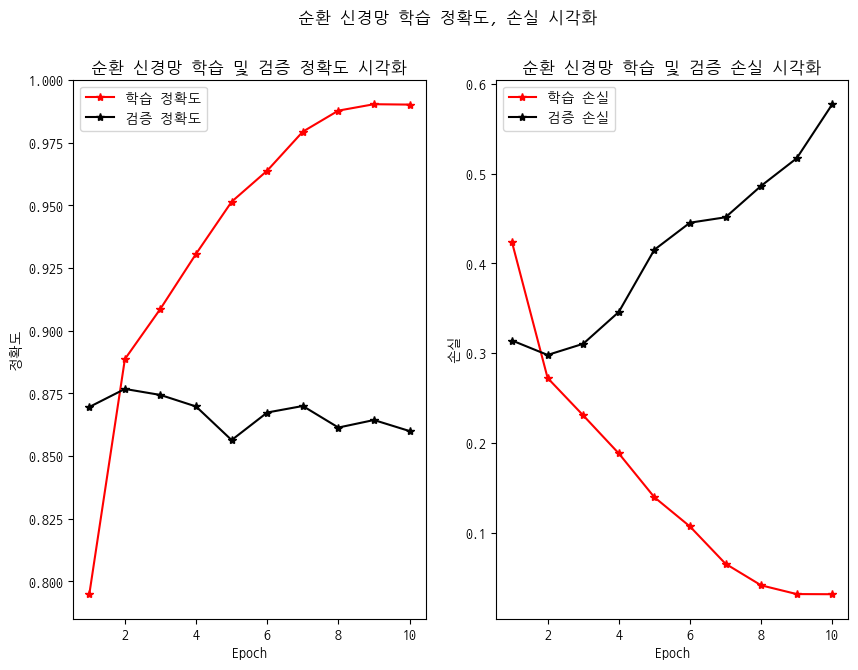

In [24]:
epoch = np.arange(1, 11) # x축 역할
accuracy = history.history['Accuracy'] # epoch별 학습 데이터 정확도
loss = history.history['loss'] # epoch별 학습 데이터 손실, 오차
val_accuracy = history.history['val_Accuracy'] # epoch별 검증 데이터 정확도
val_loss = history.history['val_loss'] #epoch별 검증 데이터 손실, 오차

plt.figure(figsize=[10, 7])
# 학습 정확도, 검증 정확도 시각화
plt.subplot(1, 2, 1)
plt.plot(epoch, accuracy, "r*-", label = "학습 정확도")  # 학습 정확도 차트
plt.plot(epoch, val_accuracy, "k*-", label = "검증 정확도")  # 검증 정확도 차트
plt.title("순환 신경망 학습 및 검증 정확도 시각화")
plt.xlabel("Epoch")
plt.ylabel("정확도")
plt.legend()

# 학습 손실, 검증 손실 시각화
plt.subplot(1, 2, 2)
plt.plot(epoch, loss, "r*-", label = "학습 손실")  # 학습 손실 차트
plt.plot(epoch, val_loss, "k*-", label = "검증 손실")  # 검증 손실 차트
plt.title("순환 신경망 학습 및 검증 손실 시각화")
plt.xlabel("Epoch")
plt.ylabel("손실")
plt.legend()

plt.suptitle("순환 신경망 학습 정확도, 손실 시각화")
plt.show()


